In [4]:
import sys
sys.path.append('../')

import os
from utils import DataSeq, load_ids, load_pickle_ma

import numpy as np
import pandas as pd
import skimage.io as io

from matplotlib import pyplot as plt

from sklearn.metrics import classification_report
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.losses import Loss

import keras_tuner as kt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [5]:
pkl_path = "../pkl/train_crowdsourced_labels.pkl"
images_path = "../Train_non_experts_simple/"
test_path = "../Test/"
batch_size = 8
epochs = 10
R = 20
K = 3

In [6]:
ids, labels = load_pickle_ma(pkl_path, images_path, R)
ids, labels = shuffle(ids, labels, random_state=42)
print(ids.shape, labels.shape)

test_ids, test_labels = load_ids(test_path)
test_ids, test_labels = shuffle(test_ids, test_labels, random_state=42)
print(test_ids.shape, test_labels.shape)

(75243,) (75243, 20)
(4364,) (4364, 3)


In [7]:
class GCCELoss(Loss):
    def __init__(self, R=20, K=3, q=0.1):
        super().__init__()
        self.R = R
        self.K = K
        self.q = q
        
    
    def call(self, y_true, y_pred):
        ann = y_pred[:, :self.R]
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9)
        y_true_onehot = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1) # N * K * R
        y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis=-1) # N * K * R
        p_gcce = y_true_onehot * (1 - y_hat**self.q) / self.q
        temp1 = ann*tf.math.reduce_sum(p_gcce, axis=1)
        temp2 = (1 - ann) * (1-(1/self.K)**self.q) / self.q*tf.reduce_sum(y_true_onehot,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))
        

In [8]:
train_seq = DataSeq(ids, labels)
test_seq = DataSeq(test_ids, test_labels)

train_steps = len(ids) // batch_size
test_steps = len(test_ids) // batch_size

In [9]:
def build_model(q: float):
    input_layer = Input(shape=(224, 224, 3))

    data_augmentation = tf.keras.Sequential([
        input_layer,
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.15),
    ])
    
    vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_tensor=data_augmentation.output)
    vgg.load_weights('../h5/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
    vgg.trainable = False

    model = vgg.output
    model = Flatten()(model)
    model = Dense(4096, activation='relu')(model)
    model = Dropout(0.25)(model)

    model = Dense(3, activation='softmax')(model)

    output_R = tf.keras.layers.Dense(R,activation="sigmoid", name='output_R')(model)
 
    output_K = tf.keras.layers.Dense(K,activation="softmax", name='output_K')(model)

    model = tf.keras.layers.concatenate([output_R, output_K])

    model = Model(input_layer, model, name="VGG16_GCCE")
    
    model.compile(optimizer="adam", loss=GCCELoss(R, K, q))
    return model

In [22]:
model = build_model(0.1)
history = model.fit(train_seq, steps_per_epoch=train_steps, epochs=10)

Epoch 1/10
9405/9405 [==============================] - 455s 48ms/step - loss: 11.1450
Epoch 2/10
9405/9405 [==============================] - 452s 48ms/step - loss: 10.9641
Epoch 3/10
9405/9405 [==============================] - 452s 48ms/step - loss: 10.9451
Epoch 4/10
9405/9405 [==============================] - 451s 48ms/step - loss: 10.9409
Epoch 5/10
9405/9405 [==============================] - 452s 48ms/step - loss: 10.9408
Epoch 6/10
9405/9405 [==============================] - 452s 48ms/step - loss: 10.9397
Epoch 7/10
9405/9405 [==============================] - 451s 48ms/step - loss: 10.9387
Epoch 8/10
9405/9405 [==============================] - 452s 48ms/step - loss: 10.9394
Epoch 9/10
9405/9405 [==============================] - 453s 48ms/step - loss: 10.9384
Epoch 10/10
9405/9405 [==============================] - 452s 48ms/step - loss: 10.9371


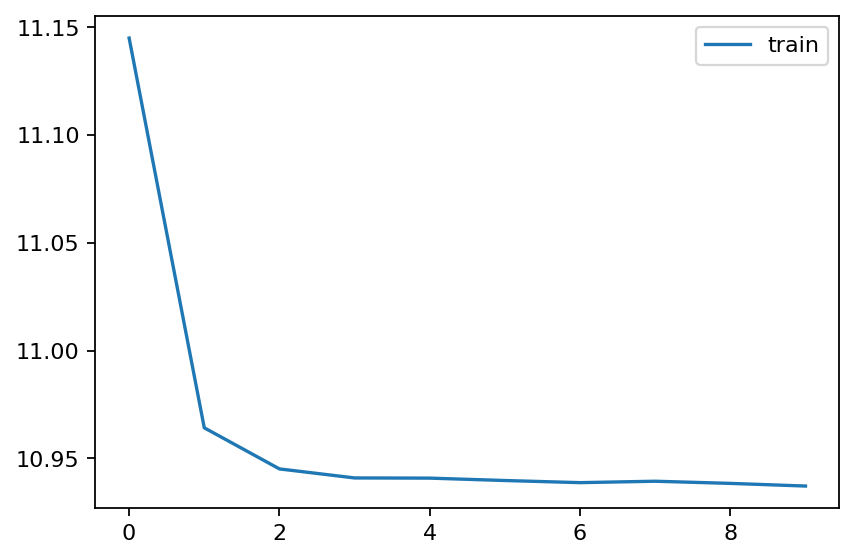

In [23]:
plt.figure(figsize=(6, 4), dpi=160)
plt.plot(history.history["loss"], label="train")
plt.legend()
plt.show()

In [24]:
y_pred = model.predict(test_seq)


546/546 [==============================] - 18s 32ms/step


In [28]:
pred = y_pred[:, R:]
print(pred)

[[0.50422955 0.37862834 0.11714211]
 [0.50422955 0.37862834 0.11714211]
 [0.50422955 0.37862834 0.11714211]
 ...
 [0.50422955 0.37862834 0.11714211]
 [0.50422955 0.37862834 0.11714211]
 [0.50422955 0.37862834 0.11714211]]


In [29]:
pred = np.argmax(pred,axis=1)
print(classification_report(np.argmax(test_labels, axis=1), pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76      2692
           1       0.00      0.00      0.00      1196
           2       0.00      0.00      0.00       476

    accuracy                           0.62      4364
   macro avg       0.21      0.33      0.25      4364
weighted avg       0.38      0.62      0.47      4364



/home/mlbros/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mlbros/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mlbros/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.save_weights('./bcss_aug_weights_mv_cce.h5')